In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.initializers import RandomNormal, Zeros, HeNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [8]:
# 1. Data Preprocessing
#def preprocess_data(data_path):
# Load the dataset
data_path = 'flipkart_com-ecommerce_sample.csv'
df = pd.read_csv(data_path)

# Select only the relevant features
df = df[['product_name', 'product_category_tree', 'retail_price', 'discounted_price', 'overall_rating', 'brand']]

# Fill missing values in 'overall_rating' with the mean
df['overall_rating'] = pd.to_numeric(df['overall_rating'], errors='coerce')  # Convert to numeric, coercing errors

# Modify 'product_category_tree' to select the first category before ">>"
df['product_category_tree'] = df['product_category_tree'].str.split('>>').str[0].str.strip()

# Handle missing values in 'brand' and 'product_name'
df['brand'] = df['brand'].fillna('Unknown')
df.fillna({'brand':'unknown'}, inplace = True)
# Fill missing values in product_name and overall_rating
df.fillna({'product_name': 'unknown'},inplace= True)
df.fillna({'overall_rating': df['overall_rating'].mean()}, inplace=True)
df.fillna({'retail_price':0}, inplace = True)
df.fillna({'discounted_price':0}, inplace=True)


## Apply Label Encoding for 'product_category_tree' and 'brand'
#label_encoders = {}
#for col in ['product_category_tree', 'brand']:
#    le = LabelEncoder()
#    df[col] = le.fit_transform(df[col])
#    label_encoders[col] = le

# Return the processed dataframe and the label encoders


        retail_price  discounted_price  overall_rating
count   20000.000000      20000.000000    20000.000000
mean     2967.587200       1965.705500        3.807085
std      8993.969648       7320.304316        0.383582
min         0.000000          0.000000        1.000000
25%       650.000000        350.000000        3.807085
50%      1007.000000        549.000000        3.807085
75%      1999.000000        999.000000        3.807085
max    571230.000000     571230.000000        5.000000

Missing values in each column:
 product_name             0
product_category_tree    0
retail_price             0
discounted_price         0
overall_rating           0
brand                    0
dtype: int64


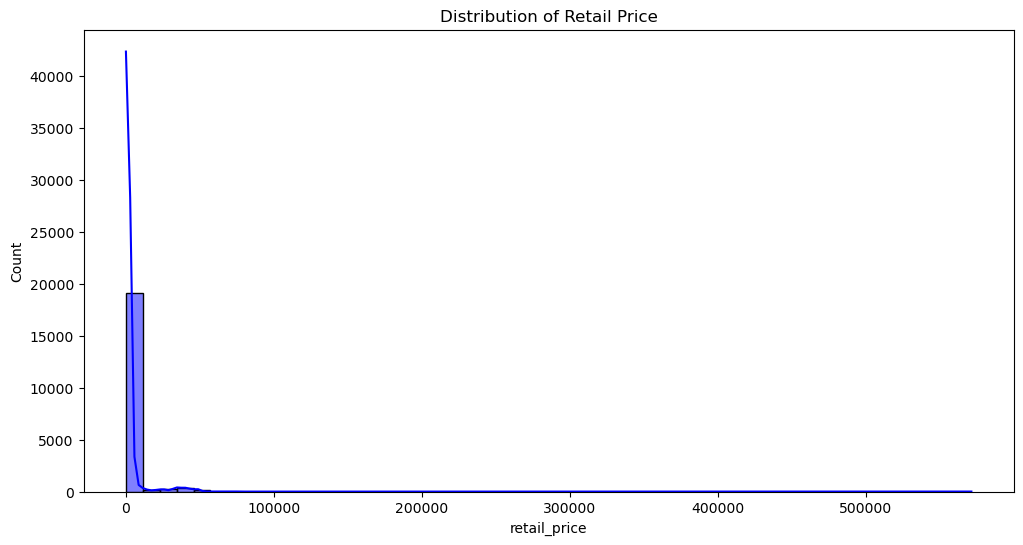

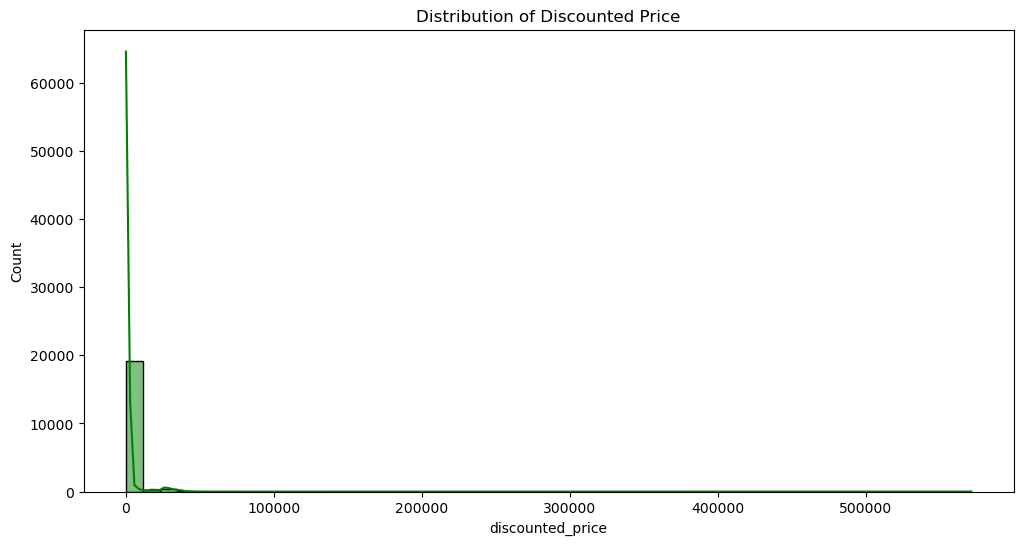

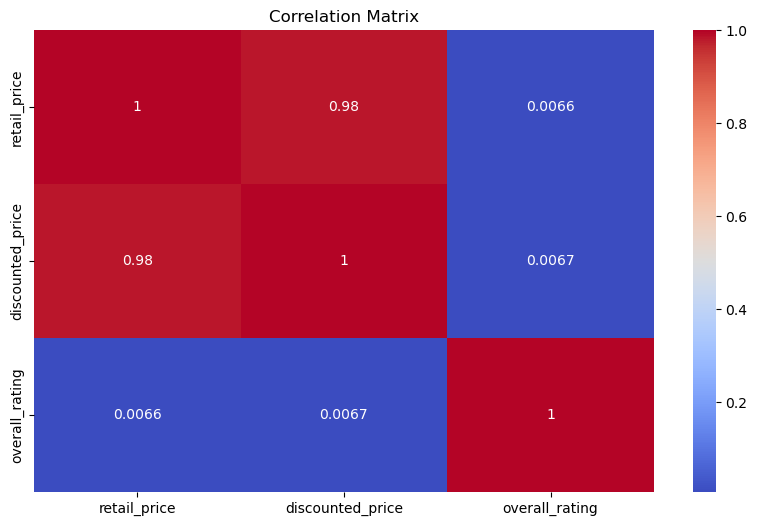

In [9]:
# 2. Exploratory Data Analysis (EDA)
#def eda(df):
# Summary of the dataset
print(df.describe())

# Check for missing values
print("\nMissing values in each column:\n", df.isnull().sum())

# Plot the distribution of 'retail_price' and 'discounted_price'
plt.figure(figsize=(12, 6))
sns.histplot(df['retail_price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Retail Price')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df['discounted_price'], bins=50, kde=True, color='green')
plt.title('Distribution of Discounted Price')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 6))

# Select only numerical features for correlation analysis
numerical_df = df.select_dtypes(include=['number'])

sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [10]:
# 3. Remove outliers using the Z-score method
#def remove_outliers(df):
z_scores = np.abs(stats.zscore(df[['retail_price', 'discounted_price', 'overall_rating']]))
df_cleaned = df[(z_scores < 3).all(axis=1)]
#return df_cleaned

In [13]:
#4. Feature Engineering and Model Creation
# Target and features
X = df[['product_name', 'product_category_tree', 'retail_price', 'overall_rating', 'brand']]
y = df['discounted_price']

# Handle text data using TfidfVectorizer
tfidf_vectorizer_name = TfidfVectorizer(max_features=100, stop_words=None)  # Increase max_features for better representation
product_name_tfidf = tfidf_vectorizer_name.fit_transform(X['product_name']).toarray()

# Apply Label Encoding for 'product_category_tree' and 'brand'
label_encoders = {}
for col in ['product_category_tree', 'brand']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Combine the features (TF-IDF and numeric features)
X_combined = np.concatenate([
    product_name_tfidf,
    X[['retail_price', 'product_category_tree', 'overall_rating', 'brand']].values
], axis=1)

# Scale the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a more complex model
model = Sequential([
    Dense(512,  # Increased number of neurons
          activation='relu',
          kernel_initializer=HeNormal(),
          bias_initializer=Zeros(),
          kernel_regularizer=l2(0.000005),  # Moderate regularization
          input_shape=(X_train.shape[1],)),
    Dropout(0.4),  # Adjusted dropout rate
    BatchNormalization(),

    Dense(256,
          activation='relu',
          kernel_initializer=HeNormal(),
          bias_initializer=Zeros(),
          kernel_regularizer=l2(0.000005)),
    Dropout(0.4),
    BatchNormalization(),

    Dense(128,
          activation='relu',
          kernel_initializer=HeNormal(),
          bias_initializer=Zeros(),
          kernel_regularizer=l2(0.000005)),
    Dropout(0.4),
    BatchNormalization(),

    Dense(64,
          activation='relu',
          kernel_initializer=HeNormal(),
          bias_initializer=Zeros(),
          kernel_regularizer=l2(0.000005)),
    Dropout(0.4),
    BatchNormalization(),

    Dense(32,
          activation='relu',
          kernel_initializer=HeNormal(),
          bias_initializer=Zeros(),
          kernel_regularizer=l2(0.000005)),
    Dropout(0.4),
    BatchNormalization(),

    Dense(1,  # Output layer for regression
          kernel_initializer=HeNormal(),
          bias_initializer=Zeros())
])

# Set a learning rate and optimizer
optimizer = Adam(learning_rate=0.0001)  # Adjusted learning rate for better convergence

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Learning rate scheduler and early stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


C:\Users\wasi\AppData\Local\Temp\ipykernel_11980\205577283.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\wasi\AppData\Local\Temp\ipykernel_11980\205577283.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\wasi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `In

In [14]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 66877628.0000 - val_loss: 50808196.0000 - learning_rate: 1.0000e-04
Epoch 2/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 48102840.0000 - val_loss: 50784736.0000 - learning_rate: 1.0000e-04
Epoch 3/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 53532144.0000 - val_loss: 50754448.0000 - learning_rate: 1.0000e-04
Epoch 4/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 39993912.0000 - val_loss: 50724932.0000 - learning_rate: 1.0000e-04
Epoch 5/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 47950948.0000 - val_loss: 50702140.0000 - learning_rate: 1.0000e-04
Epoch 6/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 66358224.0000 - val_loss: 50671364.0000 - learning_rate: 1.0000e-04
Epoch 7/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 49105800.0000 - val_loss: 50641760.0000 - learning_rate: 1.0000e-04
Epoch 8/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 72547096.0000 - val_loss: 50587208.0

In [ ]:
# 5. Main function to run everything
#def main(data_path):
# Preprocess the data
#df = preprocess_data(data_path) # Pass the data_path to preprocess_data function

# EDA
#eda(df)

# Remove outliers
#df_cleaned = remove_outliers(df)

# Feature engineering and model training
#model, history, scaler, tfidf_vectorizer_name, label_encoders = feature_engineering_and_model(df_cleaned)

# Save the model and preprocessing objects
model.save('discounted_price_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(tfidf_vectorizer_name, 'tfidf_vectorizer_name.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

In [ ]:
#if __name__ == "__main__":
#    data_path = '/content/drive/MyDrive/class IA Project/flipkart_com-ecommerce_sample.csv'  # Replace with your CSV file path
#    main(data_path)